In [1]:
#Predicting Poisonous mushrooms using  XGBClassifier

In [2]:
import pandas as pd
import numpy as np


from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
# read data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [3]:
X = pd.read_csv("../datasets/mushrooms/train.csv")


In [4]:
X.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [5]:
y = X["class"].values.ravel()
X.drop(columns=["id","class"],inplace=True)


y





array(['e', 'p', 'e', ..., 'p', 'e', 'p'], dtype=object)

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
y_test

array([1, 1, 0, ..., 1, 0, 1])

In [9]:
null_percentage_train = X_train.isnull().sum() / X.shape[0] * 100
null_percentage_train.sort_values()


stem-width               0.000000
stem-height              0.000000
season                   0.000000
cap-diameter             0.000128
does-bruise-or-bleed     0.000192
cap-color                0.000321
has-ring                 0.000545
stem-color               0.000930
cap-shape                0.001091
habitat                  0.001155
gill-color               0.001283
ring-type                3.310581
gill-attachment         13.449323
cap-surface             17.211597
gill-spacing            32.286646
stem-surface            50.848411
veil-color              70.344263
stem-root               70.765926
spore-print-color       73.134720
veil-type               75.905638
dtype: float64

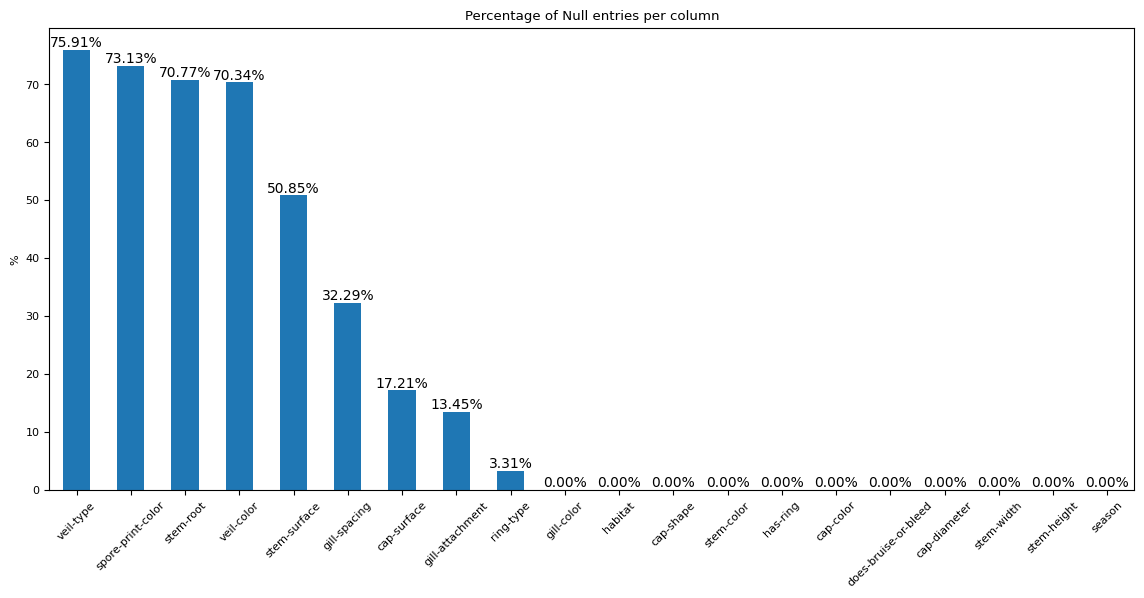

In [10]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(14,6))
ax = null_percentage_train.sort_values(ascending=False).plot(kind="bar")

for index, value in enumerate(null_percentage_train.sort_values(ascending=False)):
    ax.text(index, value + 0.5, f'{value:.2f}%', ha='center', fontsize=10)

ax.set_ylabel('%')
ax.set_title('Percentage of Null entries per column')

plt.xticks(rotation=45)  # Rotating labels by 45 degrees
plt.show()

SELECT COLUMNS TO DROP BASED ON THE PERCENTAGE OF NULL ENTRIES

In [11]:
columns_to_drop = null_percentage_train.loc[lambda x : x>20].index.to_list()

columns_to_drop

['gill-spacing',
 'stem-root',
 'stem-surface',
 'veil-type',
 'veil-color',
 'spore-print-color']

In [12]:
X_train = X_train.drop(columns=columns_to_drop)
X_train.shape

(2493556, 14)

In [13]:
#align test data shape with train
X_test = X_test.drop(columns=columns_to_drop)

PREPARING CATEGORICAL COLUMNS

In [14]:
X_train.dtypes

cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-color               object
stem-height             float64
stem-width              float64
stem-color               object
has-ring                 object
ring-type                object
habitat                  object
season                   object
dtype: object

In [15]:
X_train.select_dtypes(include=object).isnull().sum()

cap-shape                   34
cap-surface             536476
cap-color                   10
does-bruise-or-bleed         6
gill-attachment         419208
gill-color                  40
stem-color                  29
has-ring                    17
ring-type               103189
habitat                     36
season                       0
dtype: int64

IMPUTE NAN CATEGORICAL VARIABLES USING THE MOST FREQUENT METHOD

In [16]:
categorical_columns = X_train.select_dtypes(include=object).columns
numerical_columns = X_train.drop(columns=categorical_columns).columns
print("NUMERICAL COLUMNS:",' '.join(numerical_columns),"\n","CATEGORICAL COLUMNS:", ' '.join(categorical_columns))

NUMERICAL COLUMNS: cap-diameter stem-height stem-width 
 CATEGORICAL COLUMNS: cap-shape cap-surface cap-color does-bruise-or-bleed gill-attachment gill-color stem-color has-ring ring-type habitat season


In [17]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_columns] = imputer.fit_transform(X_train[categorical_columns])
X_test[categorical_columns] = imputer.fit_transform(X_test[categorical_columns])

In [18]:
#TEST FOR NULL VALUES AFTER IMPUTING
print("TRAIN:\n", X_train.select_dtypes(include=object).isnull().sum())
print("TEST:\n", X_test.select_dtypes(include=object).isnull().sum())


TRAIN:
 cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-color              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64
TEST:
 cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-color              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64


In [19]:
#CHANGE CARDINALITY OF EACH CATEGORICAL COLUMN.
#IF A CATEGORY MAKES UP LESS THAN 1% of entries then add it to a new group called OTHER
for col in categorical_columns:
    category_counts = X_train[col].value_counts()
    threshold = 0.01*len(X_train)
    categories_to_replace = category_counts[category_counts<threshold].index
    categories_to_keep = category_counts[category_counts>threshold].index
    X_train[col] = X_train[col].replace(categories_to_replace,"other")
    X_test[col] = X_test[col].apply(lambda x: x if x in categories_to_keep else 'other')
    


<Figure size 1400x600 with 0 Axes>

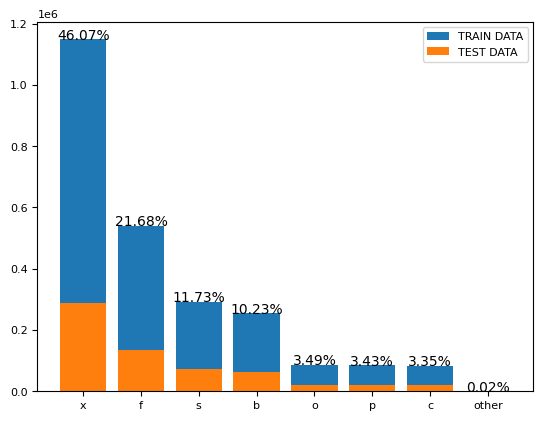

<Figure size 1400x600 with 0 Axes>

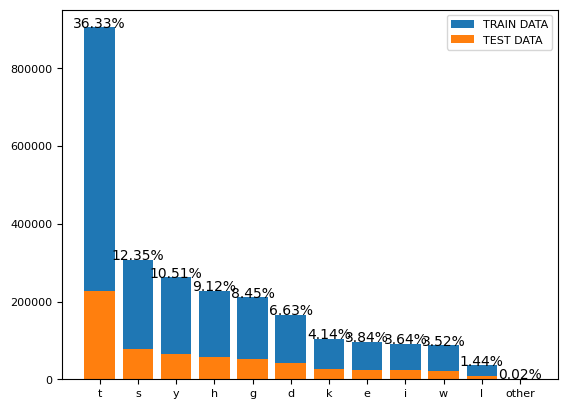

<Figure size 1400x600 with 0 Axes>

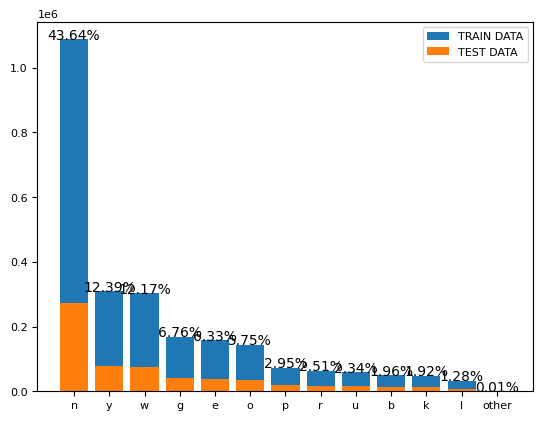

<Figure size 1400x600 with 0 Axes>

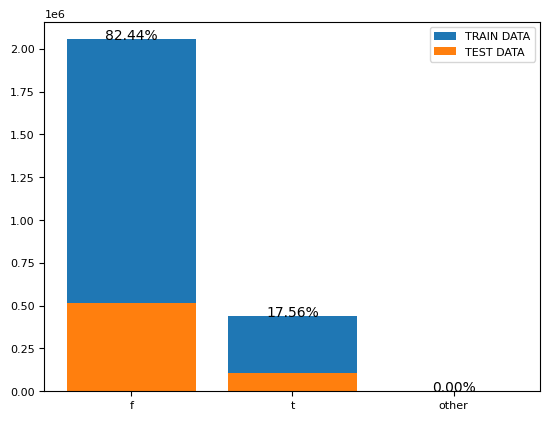

<Figure size 1400x600 with 0 Axes>

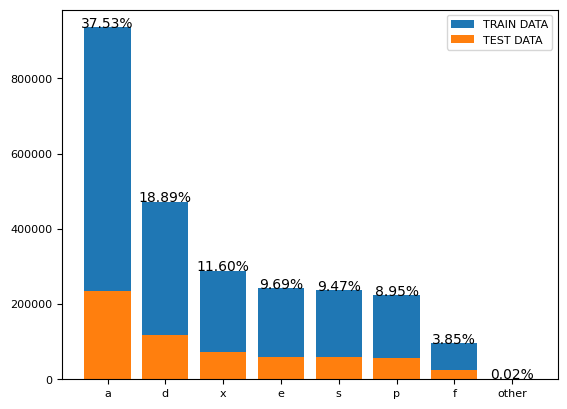

<Figure size 1400x600 with 0 Axes>

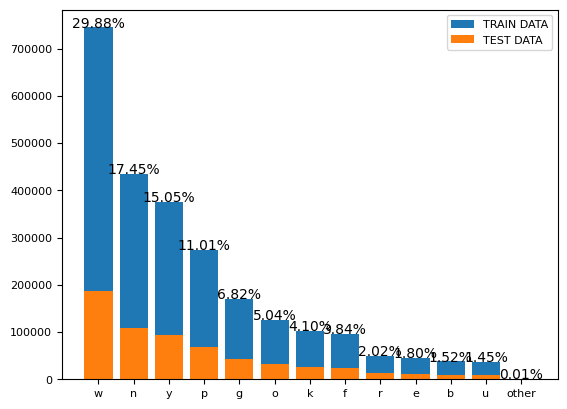

<Figure size 1400x600 with 0 Axes>

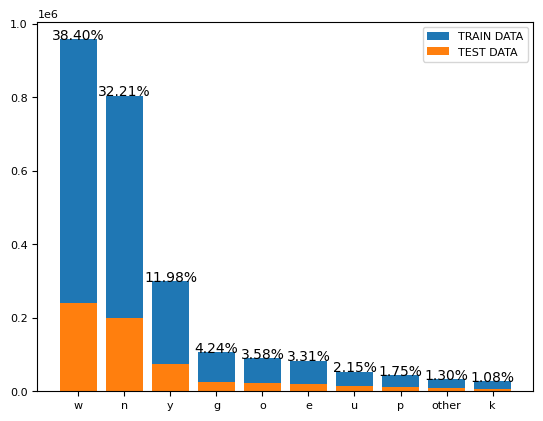

<Figure size 1400x600 with 0 Axes>

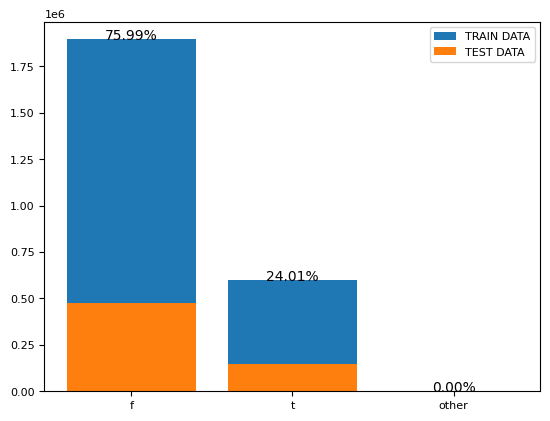

<Figure size 1400x600 with 0 Axes>

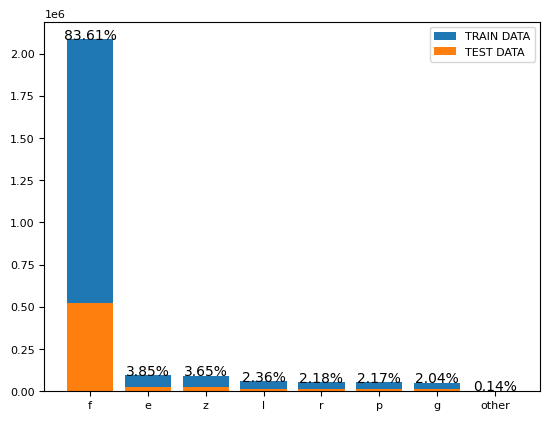

<Figure size 1400x600 with 0 Axes>

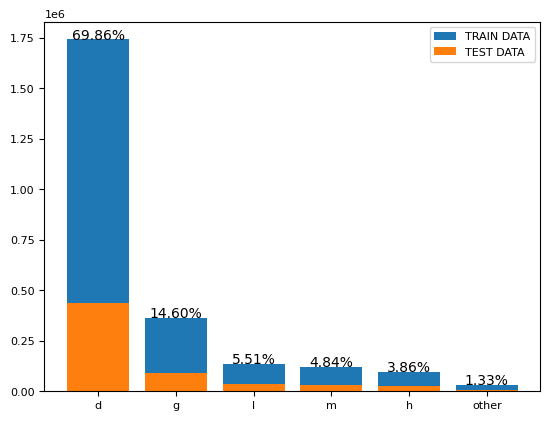

<Figure size 1400x600 with 0 Axes>

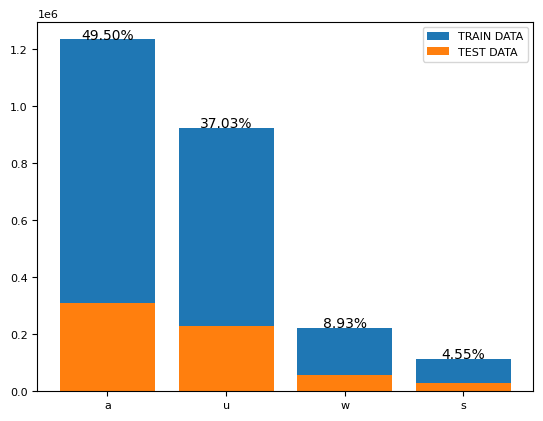

In [20]:
for col in categorical_columns:
    categories = X_train[col].value_counts()
    categories_test = X_test[col].value_counts()
    plt.figure(figsize=(14,6))
    #ax = categories.plot(kind="bar")
    fig, ax = plt.subplots()
    ax.bar(categories.index,categories.to_list(),label='TRAIN DATA')
    ax.bar(categories_test.index,categories_test.to_list(), label="TEST DATA")
    for index, value in enumerate(categories):
        ax.text(index, value + 0.5, f'{value/categories.sum()*100:.2f}%', ha='center', fontsize=10)
    ax.legend()
    plt.show()


ORDINAL ENCODING CATEGORICAL COLUMNS

In [21]:
from sklearn.preprocessing import OrdinalEncoder
#ordinal_encoder = OrdinalEncoder()
for col in categorical_columns:
    unique_categories = X_train[col].unique()
    ordinal_encoder = OrdinalEncoder(categories=[unique_categories])
    X_train[col] = ordinal_encoder.fit_transform(X_train[[col]])
    X_test[col]= ordinal_encoder.fit_transform(X_test[[col]])


NUMERICAL COLUMN PROCESSING

In [22]:
#CHECK FOR NAN VALUES
numerical_null_percentage = X_train[numerical_columns].isnull().sum() / X.shape[0] * 100
print("TRAIN:\n",numerical_null_percentage.sort_values())
print("TEST:\n",(X_test[numerical_columns].isnull().sum() / X.shape[0] * 100).sort_values())

TRAIN:
 stem-height     0.000000
stem-width      0.000000
cap-diameter    0.000128
dtype: float64
TEST:
 cap-diameter    0.0
stem-height     0.0
stem-width      0.0
dtype: float64


In [23]:
#IMPUTE MISSING NUMERICAL DATA IN TRAIN DATA SET
imputer = SimpleImputer(strategy='median')
X_train[['cap-diameter']] = imputer.fit_transform(X_train[['cap-diameter']])

#CHECK FOR NAN VALUES AFTER IMPUTING
numerical_null_percentage = X_train[numerical_columns].isnull().sum() / X.shape[0] * 100
numerical_null_percentage.sort_values()

cap-diameter    0.0
stem-height     0.0
stem-width      0.0
dtype: float64

COMPARING SKEWNESS OF DATA / Log transformed data BEFORE IDENTIFYING OUTLIERS

SKEWNESS OF cap-diameter COLUMN:  3.970743289841205


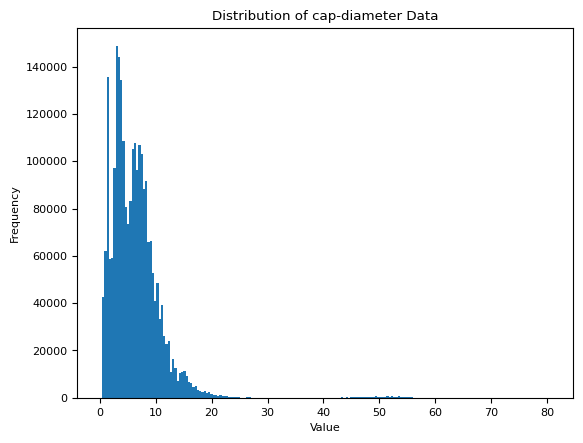

-0.11798366160464001


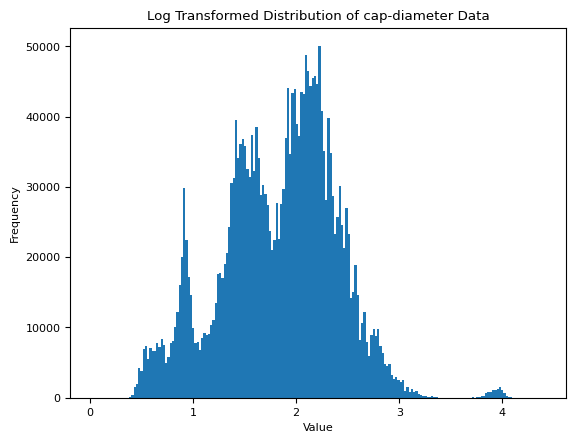

SKEWNESS OF stem-height COLUMN:  1.932079833029636


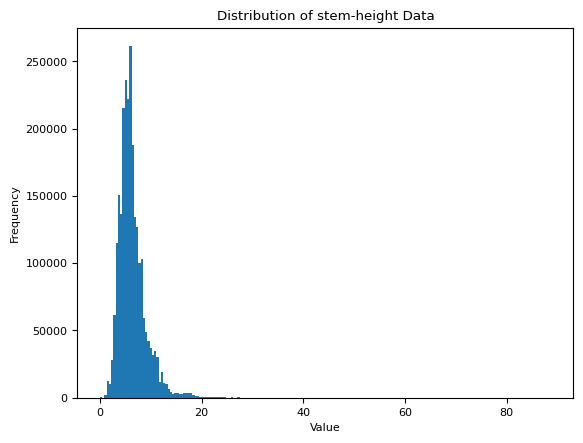

0.24169879002741088


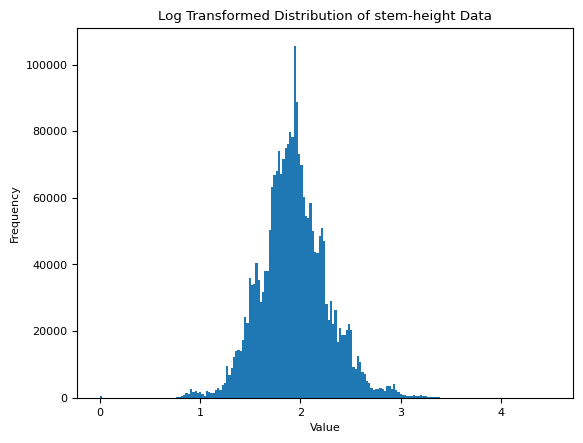

SKEWNESS OF stem-width COLUMN:  1.2340479467531145


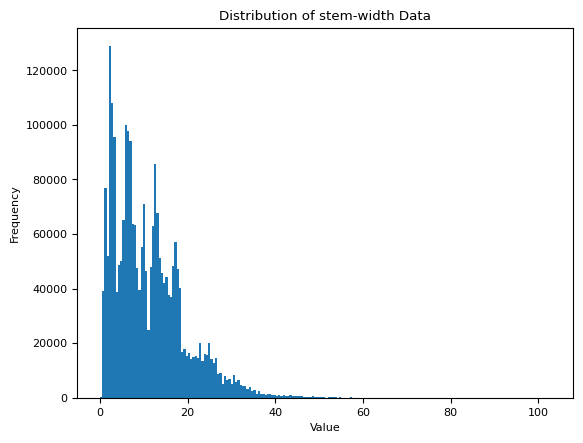

-0.31804521046096385


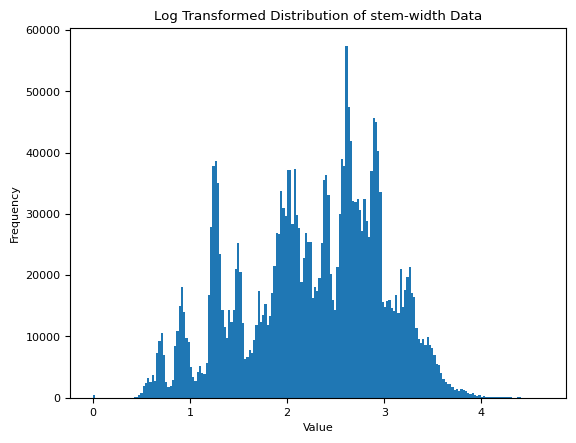

In [24]:
for col in numerical_columns:
    data = X_train[col].sort_values()
    print("SKEWNESS OF", col, "COLUMN: ", data.skew())
    plt.hist(data, bins=200)

    # Add labels and title
    plt.title(f'Distribution of {col} Data')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Show plot
    plt.show()

    data_log_transformed = np.log(data + 1)
    
    print(data_log_transformed.skew())
    plt.hist(data_log_transformed, bins=200)

    # Add labels and title
    plt.title(f'Log Transformed Distribution of {col} Data')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Show plot
    plt.show()

In [25]:
for col in numerical_columns:
    X_train[col] = np.log(X_train[col]+1)
    X_test[col] = np.log(X_test[col]+1)
    print(X_test[col].skew())

-0.1164530625995595
0.23406061235147124
-0.3174549324409754


In [26]:
#REMOVE OUTLIER IN TRAIN DATA SET
outliers=pd.DataFrame(columns=X_train.columns)
X_train_cleaned = X_train.copy()
for col in numerical_columns:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train_cleaned = X_train_cleaned[(X_train_cleaned[col] >= lower_bound) & (X_train[col] <= upper_bound)]
    

print(X_train.shape)
print(X_train_cleaned.shape)

/var/folders/3n/fwvld1h16fncxfv2jkz9b1h80000gn/T/ipykernel_64005/1093573497.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_cleaned = X_train_cleaned[(X_train_cleaned[col] >= lower_bound) & (X_train[col] <= upper_bound)]
/var/folders/3n/fwvld1h16fncxfv2jkz9b1h80000gn/T/ipykernel_64005/1093573497.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_cleaned = X_train_cleaned[(X_train_cleaned[col] >= lower_bound) & (X_train[col] <= upper_bound)]


(2493556, 14)
(2417430, 14)


In [27]:
X_train.head()


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
1252551,1.275363,0.0,0.0,0.0,0.0,0.0,0.0,1.353255,1.900614,0.0,0.0,0.0,0.0,0.0
1799166,1.040277,1.0,1.0,1.0,1.0,1.0,0.0,1.850028,1.308333,0.0,0.0,0.0,1.0,0.0
1936146,1.827770,2.0,2.0,1.0,1.0,2.0,1.0,2.118662,2.129421,1.0,0.0,0.0,1.0,0.0
1464811,1.708378,3.0,3.0,2.0,1.0,3.0,1.0,1.924249,2.620311,2.0,0.0,0.0,0.0,0.0
767639,1.971299,3.0,3.0,0.0,1.0,0.0,1.0,1.991976,2.423917,0.0,0.0,0.0,2.0,1.0


In [28]:
y_train

array([1, 1, 1, ..., 1, 1, 0])

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1,max_depth=5, random_state=0,verbose=1).fit(X_train, y_train)
clf.score(X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1           1.3063           22.78m
         2           1.2504           22.46m
         3           1.1995           22.33m
         4           1.1569           22.22m
         5           1.1172           22.21m
         6           1.0773           22.26m
         7           1.0383           22.18m
         8           1.0063           22.15m
         9           0.9710           22.20m
        10           0.9424           22.28m
        20           0.7297           21.62m
        30           0.6085           20.74m
        40           0.5345           20.01m
        50           0.4665           19.26m
        60           0.4174           18.52m
        70           0.3746           17.74m
        80           0.3428           16.98m
        90           0.3137           16.18m
       100           0.2903           15.39m
       200           0.1581            7.63m
       300           0.1258            0.00s


0.9843356235031417

In [34]:
y_pred = clf.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)

report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

print(y_pred.shape)

Accuracy: 0.98
Confusion Matrix:
[[277990   4407]
 [  5358 335634]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    282397
           1       0.99      0.98      0.99    340992

    accuracy                           0.98    623389
   macro avg       0.98      0.98      0.98    623389
weighted avg       0.98      0.98      0.98    623389

(623389,)
